In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from lightkurve import KeplerTargetPixelFile
from lightkurve import SimpleKeplerPRF, PRFPhotometry, SceneModel
from lightkurve import KeplerLightCurve
from lightkurve.utils import KeplerQualityFlags
from lightkurve import KeplerCBVCorrector
from oktopus import UniformPrior
from astropy.stats import LombScargle

In [3]:
tpf = KeplerTargetPixelFile('../Data/ktwo251248520-c111_lpd-targ.fits')

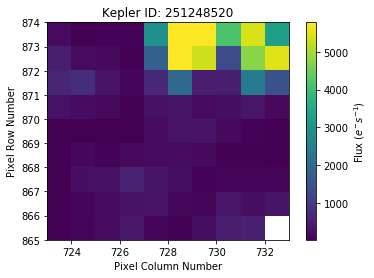

In [4]:
tpf.plot(frame=527, interpolation='nearest')

In [5]:
prf = SimpleKeplerPRF(channel=tpf.channel, shape=tpf.shape[1:], column=tpf.column, row=tpf.row)

In [6]:
scene = SceneModel(prfs=2*[prf])

In [7]:
prior = UniformPrior(lb=[3500, 728, 872, 3500, 731, 872, 0],
                    ub=[1000000, 730, 874, 1000000, 733, 874, 3000])

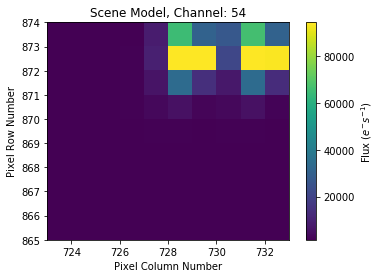

In [8]:
scene.plot(*prior.mean,interpolation='nearest')

In [9]:
phot = PRFPhotometry(scene_model=scene, prior=prior)

In [10]:
newtpf = (tpf.flux_bkg + tpf.flux)

In [11]:
results = phot.fit(newtpf)

  0%|          | 0/1061 [00:00<?, ?it/s]/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
100%|██████████| 1061/1061 [00:37<00:00, 28.06it/s]


In [12]:
flux_1 = results[:, 0]
xc_1 = results[:, 1]
yc_1 = results[:, 2]
flux_2 = results[:, 3]
xc_2 = results[:, 4]
yc_2 = results[:, 5]
bkg = results[:, -1]

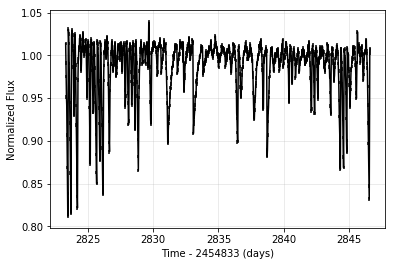

In [14]:
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
lc.plot()

In [15]:
lc_psf=KeplerLightCurve(time=tpf.time, flux=flux_1, flux_err=lc.flux_err)

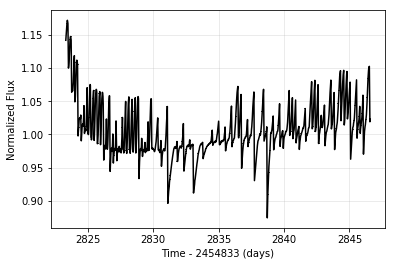

In [16]:
lc_psf = lc_psf.remove_nans().remove_outliers()
lc_psf.plot()

In [17]:
lc_flat = lc_psf.flatten(501)

In [18]:
lc_flat = lc_flat.remove_nans().remove_outliers()

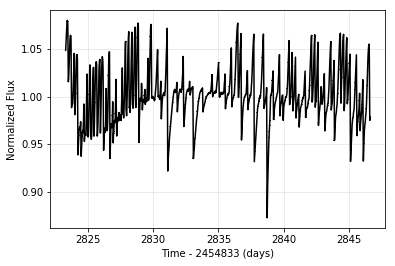

In [19]:
lc_flat.plot()

In [20]:
t = lc_flat.time
y = lc_flat.flux

In [21]:
frequency, power = LombScargle(t,y).autopower(minimum_frequency=0.066, maximum_frequency=15)
p = 1/frequency[np.argmax(power)]
print(p)

0.24513286071453738


In [22]:
LombScargle(t,y).false_alarm_probability(power.max(), method='bootstrap')

0.0040000000000000036